<a href="https://colab.research.google.com/github/prateekchandrajha/mastering-ml-algorithms/blob/main/OpenAI_Gym_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initialise**

In [1]:
%%bash
# This Cell is only used to make sure cartpole runs 

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate


Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,382 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160690 files and director

In [2]:
# This Cell is only used to make sure cartpole runs 

import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [4]:
# this is a Deep Q Learning (DQN) agent including replay memory and a target network 
# you can write a brief 8-10 line abstract detailing your submission and experiments here
# the code is based on https://github.com/seungeunrho/minimalRL/blob/master/dqn.py, which is released under the MIT licesne
# make sure you reference any code you have studied as above, with one comment line per reference

# imports
import gym
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32
video_every   = 25
print_every   = 5

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, insize, outsize):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(insize, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, outsize)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        # Q(s,a) = R(s,a) + γ*Q_targ(s_prime)*done_mask
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


**Train**

← You can download the videos from the videos folder in the files on the left

In [5]:
# setup the  environment, and record a video every 50 episodes.
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)

In [6]:
env.reset()

array([ 0.03369142, -0.00252515,  0.04711177,  0.03401396])

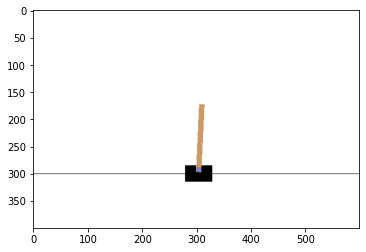

In [7]:
plt.imshow(env.render(mode='rgb_array'))

In [8]:
# reproducible environment and action spaces, do not change lines 6-11 here (tools > settings > editor > show line numbers)
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

q = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
q_target = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

score    = 0.0
marking  = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_episode in range(1001):
    epsilon = max(0.01, 0.08 - 0.01*(n_episode/200)) # linear annealing from 8% to 1%
    s = env.reset()
    done = False
    score = 0.0

    while True:

        a = q.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0
        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime

        score += r
        if done:
            break
        
    if memory.size()>2000:
        train(q, q_target, memory, optimizer)

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        q_target.load_state_dict(q.state_dict())
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 9.0, mean_score: 9.00, std_score: 0.00
episode: 5, score: 10.0, epsilon: 0.08
episode: 10, score: 9.0, epsilon: 0.08
episode: 15, score: 8.0, epsilon: 0.08
episode: 20, score: 9.0, epsilon: 0.08
episode: 25, score: 10.0, epsilon: 0.08
episode: 30, score: 10.0, epsilon: 0.08
episode: 35, score: 9.0, epsilon: 0.08
episode: 40, score: 8.0, epsilon: 0.08
episode: 45, score: 10.0, epsilon: 0.08
episode: 50, score: 8.0, epsilon: 0.08
episode: 55, score: 11.0, epsilon: 0.08
episode: 60, score: 10.0, epsilon: 0.08
episode: 65, score: 11.0, epsilon: 0.08
episode: 70, score: 8.0, epsilon: 0.08
episode: 75, score: 10.0, epsilon: 0.08
episode: 80, score: 9.0, epsilon: 0.08
episode: 85, score: 10.0, epsilon: 0.08
episode: 90, score: 9.0, epsilon: 0.08
episode: 95, score: 10.0, epsilon: 0.08
marking, episode: 100, score: 8.0, mean_score: 9.61, std_score: 1.05
episode: 100, score: 8.0, epsilon: 0.07
episode: 105, score: 10.0, epsilon: 0.07
episode: 110, score: 9.0, epsilon

In [9]:
# Custom environment
# "Play your cards right"
drawn_count = 7
highest_card = 9
# Construct our action space
obv_space = gym.spaces.MultiBinary([drawn_count, highest_card+1])
act_space = gym.spaces.Discrete(2)

class Brucey(gym.Env):
  reward_range = (0,1)
  action_space = act_space
  observation_space = obv_space
  _max_episode_steps = drawn_count-1
  deck = [x for x in range(1,highest_card+1)]
  cards = "-123456789"
  guess='LH'

  def __init__(self):
    super().__init__()
  
  def reset(self):
    self.steps=1
    self.hidden_cards = random.sample(self.deck, drawn_count)
    self.guesses=[]
    obs = [0] * drawn_count
    obs[:self.steps] = self.hidden_cards[:self.steps]
    obs = np.array(obs)
    # Fancy onehot encoding
    onehot = np.zeros((obs.size, highest_card+1))
    onehot[np.arange(obs.size),obs] = 1
    return onehot

  def step(self, action):
    self.guesses.append(action)
    info = dict()
    cardhigher = self.hidden_cards[self.steps] > self.hidden_cards[self.steps-1] 
    self.steps += 1 
    obs = [0] * drawn_count
    obs[:self.steps] = self.hidden_cards[:self.steps]
    obs = np.array(obs)
    # Fancy onehot encoding
    onehot = np.zeros((obs.size, highest_card+1))
    onehot[np.arange(obs.size),obs] = 1
    if cardhigher == action:
      reward = 1
      if self.steps != len(self.hidden_cards):
        done = False
      else:
        done = True
    else:
      reward = 0
      done = True
    

    return onehot, reward, done, info

  def render(self):
    obs = [0] * drawn_count
    obs[:self.steps] = self.hidden_cards[:self.steps]
    rend = "{}\n{}\n{}".format(
        ''.join(self.cards[i] for i in obs),
        ''.join(self.guess[i] for i in self.guesses),
        ''.join(self.cards[i] for i in self.hidden_cards),
    )
    print(rend)
    return rend
    



In [10]:
env = Brucey()
env.reset()
env.render()


8------

8971624


'8------\n\n8971624'

In [11]:
env.step(0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 0, True, {})

In [12]:
env.step(1)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 0, True, {})

In [13]:
env.render()

897----
LH
8971624


'897----\nLH\n8971624'

In [14]:
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

q = QNetwork(drawn_count * (highest_card+1), 2)
q_target = QNetwork(drawn_count * (highest_card+1), 2)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

score    = 0.0
scores = []
marking  = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_episode in range(10001):
    epsilon = 0.08
    s = env.reset()
    done = False
    score = 0.0

    while True:

        a = q.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0
        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime

        score += r
        if done:
            break
        
    if memory.size()>2000:
        train(q, q_target, memory, optimizer)
    scores.append(score)
    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        q_target.load_state_dict(q.state_dict())
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 2.0, mean_score: 2.00, std_score: 0.00
episode: 5, score: 0.0, epsilon: 0.08
episode: 10, score: 0.0, epsilon: 0.08
episode: 15, score: 0.0, epsilon: 0.08
episode: 20, score: 0.0, epsilon: 0.08
episode: 25, score: 1.0, epsilon: 0.08
episode: 30, score: 0.0, epsilon: 0.08
episode: 35, score: 0.0, epsilon: 0.08
episode: 40, score: 1.0, epsilon: 0.08
episode: 45, score: 3.0, epsilon: 0.08
episode: 50, score: 1.0, epsilon: 0.08
episode: 55, score: 1.0, epsilon: 0.08
episode: 60, score: 0.0, epsilon: 0.08
episode: 65, score: 0.0, epsilon: 0.08
episode: 70, score: 0.0, epsilon: 0.08
episode: 75, score: 1.0, epsilon: 0.08
episode: 80, score: 2.0, epsilon: 0.08
episode: 85, score: 0.0, epsilon: 0.08
episode: 90, score: 0.0, epsilon: 0.08
episode: 95, score: 1.0, epsilon: 0.08
marking, episode: 100, score: 2.0, mean_score: 0.81, std_score: 1.09
episode: 100, score: 2.0, epsilon: 0.08
episode: 105, score: 1.0, epsilon: 0.08
episode: 110, score: 0.0, epsilon: 0.08
epis

In [15]:
class OptimalPolicy(object):
    def __init__(self):
        super().__init__()

    def calc(self, x):
        cardsleft = torch.ones(highest_card+1)
        for card in x:
          newval = card.argmax().item()
          cardsleft[newval] = 0
          if newval == 0:
            break
          else:
            val = newval
        lower_sum = cardsleft[1:val].sum()
        higher_sum = cardsleft[val:].sum()
        action = int(lower_sum < higher_sum)
        return action
      
    def sample_action(self, obs, epsilon):
        out = self.calc(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out

class RandomPolicy(object):
    def __init__(self):
        super().__init__()

    def sample_action(self, obs, epsilon):
          return random.randint(0,1)


In [16]:
good_pol = OptimalPolicy()
bad_pol = RandomPolicy()

In [17]:
marking  = []
opt_scores = []
for n_episode in range(10001):
    epsilon = 0.08
    s = env.reset()
    done = False
    score = 0.0

    while True:
        a = good_pol.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)
        s = s_prime
        score += r
        if done:
            break
    opt_scores.append(score)

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 0.0, mean_score: 0.00, std_score: 0.00
episode: 5, score: 2.0, epsilon: 0.08
episode: 10, score: 5.0, epsilon: 0.08
episode: 15, score: 0.0, epsilon: 0.08
episode: 20, score: 1.0, epsilon: 0.08
episode: 25, score: 5.0, epsilon: 0.08
episode: 30, score: 2.0, epsilon: 0.08
episode: 35, score: 2.0, epsilon: 0.08
episode: 40, score: 0.0, epsilon: 0.08
episode: 45, score: 0.0, epsilon: 0.08
episode: 50, score: 2.0, epsilon: 0.08
episode: 55, score: 6.0, epsilon: 0.08
episode: 60, score: 3.0, epsilon: 0.08
episode: 65, score: 6.0, epsilon: 0.08
episode: 70, score: 5.0, epsilon: 0.08
episode: 75, score: 6.0, epsilon: 0.08
episode: 80, score: 1.0, epsilon: 0.08
episode: 85, score: 3.0, epsilon: 0.08
episode: 90, score: 5.0, epsilon: 0.08
episode: 95, score: 4.0, epsilon: 0.08
marking, episode: 100, score: 0.0, mean_score: 2.49, std_score: 2.18
episode: 100, score: 0.0, epsilon: 0.08
episode: 105, score: 0.0, epsilon: 0.08
episode: 110, score: 0.0, epsilon: 0.08
epis

In [18]:
rand_scores = []
marking  = []
for n_episode in range(10001):
    epsilon = 0.08
    s = env.reset()
    done = False
    score = 0.0

    while True:
        a = bad_pol.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)
        s = s_prime
        score += r
        if done:
            break
    rand_scores.append(score)

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 0.0, mean_score: 0.00, std_score: 0.00
episode: 5, score: 1.0, epsilon: 0.08
episode: 10, score: 2.0, epsilon: 0.08
episode: 15, score: 0.0, epsilon: 0.08
episode: 20, score: 1.0, epsilon: 0.08
episode: 25, score: 2.0, epsilon: 0.08
episode: 30, score: 1.0, epsilon: 0.08
episode: 35, score: 0.0, epsilon: 0.08
episode: 40, score: 1.0, epsilon: 0.08
episode: 45, score: 0.0, epsilon: 0.08
episode: 50, score: 1.0, epsilon: 0.08
episode: 55, score: 0.0, epsilon: 0.08
episode: 60, score: 0.0, epsilon: 0.08
episode: 65, score: 1.0, epsilon: 0.08
episode: 70, score: 5.0, epsilon: 0.08
episode: 75, score: 1.0, epsilon: 0.08
episode: 80, score: 5.0, epsilon: 0.08
episode: 85, score: 0.0, epsilon: 0.08
episode: 90, score: 0.0, epsilon: 0.08
episode: 95, score: 0.0, epsilon: 0.08
marking, episode: 100, score: 0.0, mean_score: 1.26, std_score: 1.54
episode: 100, score: 0.0, epsilon: 0.08
episode: 105, score: 2.0, epsilon: 0.08
episode: 110, score: 0.0, epsilon: 0.08
epis

In [19]:
scores = np.array(scores)
opt_scores = np.array(opt_scores)
rand_scores = np.array(rand_scores)

In [20]:
[x.mean() for x in [scores, opt_scores, rand_scores]]

[2.121187881211879, 2.4286571342865715, 0.9958004199580042]

In [21]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

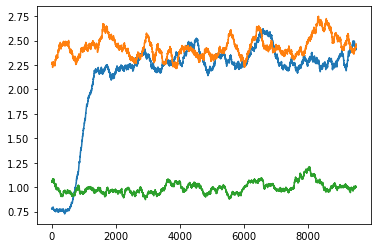

In [22]:
plt.plot(moving_average(scores, n=500))
plt.plot(moving_average(opt_scores, n=500))
plt.plot(moving_average(rand_scores, n=500))
plt.show()